In [2]:
import gzip
from tqdm import tqdm
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
path = '../dataset'
X = np.load(f'{path}/train/arr_X.npy')
Y = np.load(f'{path}/train/arr_Y.npy')
trainset = np.array([[X[i,0], Y[i]] for i in range(len(Y))])
X = np.load(f'{path}/test/arr_X.npy')
Y = np.load(f'{path}/test/arr_Y.npy')
testset = np.array([[X[i,0], Y[i]] for i in range(len(Y))])
del X
del Y

/tmp/ipykernel_2934452/1662636781.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainset = np.array([[X[i,0], Y[i]] for i in range(len(Y))])
/tmp/ipykernel_2934452/1662636781.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  testset = np.array([[X[i,0], Y[i]] for i in range(len(Y))])


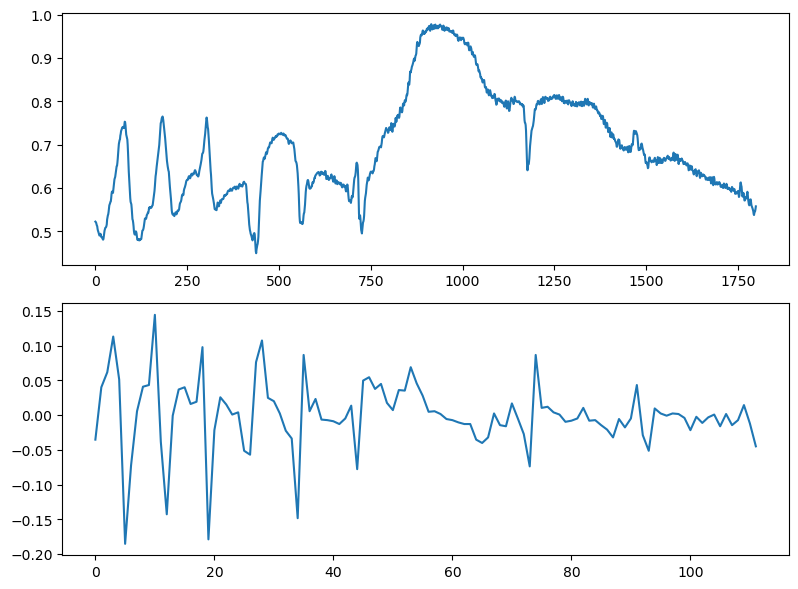

In [143]:
sample = testset[18800,0]
grad = []
foresight = 16
for i in range(len(sample)//foresight):
    grad.append(sample[(i+1)*foresight]-sample[i*foresight])
    
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(sample)
plt.subplot(2,1,2)
plt.plot(grad)
plt.tight_layout()

In [15]:
trainset.shape

(75455, 2)

In [116]:
X = np.array([])
Y = np.array([])
num_shots = 2
for i in range(6):
    tmp = np.random.choice(trainset[trainset[:,1]==i][:,0], size=num_shots, replace=False)
    X = np.hstack([X, np.array(tmp)])
    Y = np.hstack([Y, np.ones(num_shots)*i])
    


In [117]:
trainset_ = np.array([X, Y]).transpose(1,0)
trainset_[:,1] = trainset_[:,1].astype(np.int32)

In [119]:
trainset_[:,1]

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], dtype=object)

In [118]:
for i in range(6):
    print(i, len(trainset[trainset[:,1]==i]))

0 5618
1 42620
2 5328
3 17023
4 4496
5 370


In [123]:
range_ = [0, -1]
pred = []
decpoint=4
ts = {f'{i+1}':[] for i in range(5)}
for x1, y1 in tqdm(testset[range_[0]:range_[1]]):
    s1 = ' '.join(np.round(x1,decpoint).astype(str))
    Cx1 = len(gzip.compress(s1.encode()))
    distance_from_x1 = []
    for x2, _ in trainset_:
        s2 = ' '.join(np.round(x2,decpoint).astype(str))
        Cx2 = len(gzip.compress(s2.encode()))
        x1x2 = ' '.join([s1, s2])
        Cx1x2 = len(gzip.compress(x1x2.encode()))
        #ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
        #distance_from_x1.append(ncd)
        distance_from_x1.append(Cx1x2)
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = trainset_[sorted_idx[:3], 1].tolist()
    predict_class = max(set(top_k_class), key=top_k_class.count)
    pred.append(predict_class)

print(flush=True)
print(metrics.accuracy_score(y_true=testset[range_[0]:range_[1]][:,1].tolist(), y_pred=pred)*100, '%', flush=True)

100%|██████████| 18863/18863 [26:44<00:00, 11.75it/s]

ValueError: Found input variables with inconsistent numbers of samples: [75454, 18863]

In [124]:
print(metrics.accuracy_score(y_true=testset[range_[0]:range_[1]][:,1].tolist(), y_pred=pred)*100, '%', flush=True)

59.10512643800032 %


In [125]:
metrics.confusion_matrix(y_true=testset[range_[0]:range_[1]][:,1].tolist(), y_pred=pred)

array([[  494,   911,     0,     0,     0,     0],
       [    0, 10655,     0,     0,     0,     0],
       [    0,  1332,     0,     0,     0,     0],
       [    0,  4256,     0,     0,     0,     0],
       [    0,  1124,     0,     0,     0,     0],
       [    0,    91,     0,     0,     0,     0]])

In [144]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
[, #1: 'LBBB.csv', #2: 'N.csv', #3: 'PB.csv', #4: 'PVC.csv', #5: 'RBBB.csv', #6: 'VF.csv']
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"\n[, #1: 'LBBB.csv', #2: 'N.csv', #3: 'PB.csv', #4: 'PVC.csv', #5: 'RBBB.csv', #6: 'VF.csv']\n"

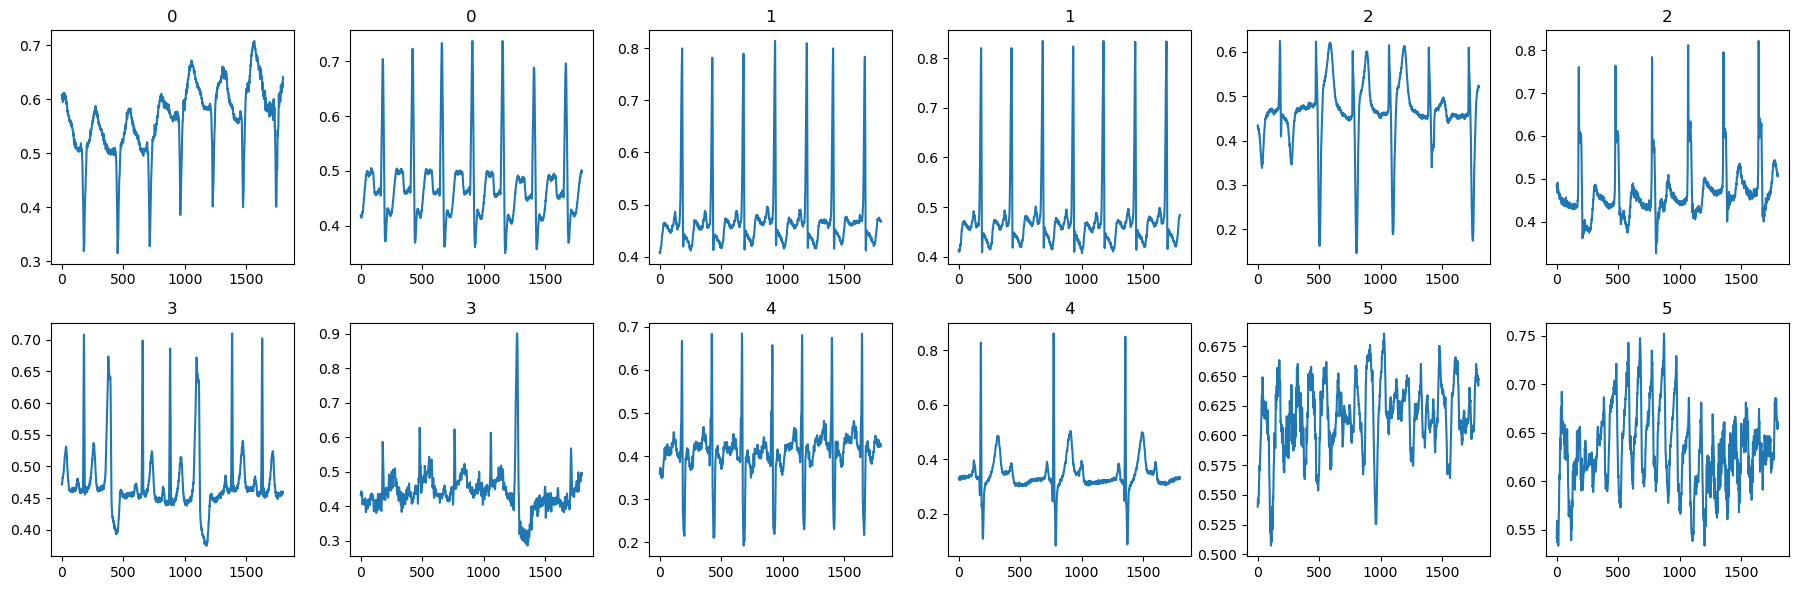

In [132]:
plt.figure(figsize=(18,6))
for i, sample in enumerate(trainset_):
    plt.subplot(2, 6, i+1)
    plt.plot(sample[0])
    plt.title(f'{sample[1]}')
plt.tight_layout()

In [14]:
correct = 0
for idx, p in enumerate(pred):
    if p == trainset[range_[0]:range_[1], 1][idx]:
        correct +=1
    # else:
    #     print(p, trainset[range_[0]:range_[1], 1][idx])

print(correct/len(pred))

0.382


In [25]:
pred = []
for x1, y1 in tqdm(trainset[range_[0]:range_[1]]):
    Cx1 = len(gzip.compress(x1.tobytes()))
    distance_from_x1 = []
    for x2, _ in testset:
        Cx2 = len(gzip.compress(x2.tobytes()))
        x1x2 = np.concatenate([x1, x2])
        Cx1x2 = len(gzip.compress(x1x2.tobytes()))
        ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
        distance_from_x1.append(ncd)
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = testset[sorted_idx[:3], 1]
    pred.append(top_k_class[0])

100%|██████████| 500/500 [00:15<00:00, 32.55it/s]


In [26]:
correct = 0
for idx, p in enumerate(pred):
    if p == trainset[range_[0]:range_[1], 1][idx]:
        correct +=1
    else:
        print(p, trainset[range_[0]:range_[1], 1][idx])
print(correct/len(pred))

2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1


In [14]:
import os
import pickle
import numpy as np
import sklearn.metrics as metrics

files = [f for f in os.listdir(f'./exp_results') if f.endswith('.pickle') and 'quant_fp_6206' in f]

In [15]:
print(len(files))

19


In [20]:
for file in files:
    with open(f'./exp_results/{file}', 'rb') as f:
        info = pickle.load(f)
    print(f"{file:<40}: {metrics.accuracy_score(info['y_true'], info['y_pred'])*100:.2f}")


quant_fp_6206_6_5_10_quant_fp.pickle    : 48.82
quant_fp_6206_6_50_quant_fp.pickle      : 55.39
quant_fp_6206_6_25_quant_fp.pickle      : 56.22
quant_fp_6206_4_10_10_quant_fp.pickle   : 19.61
quant_fp_6206_4_100_quant_fp.pickle     : 44.34
quant_fp_6206_6_100_10_quant_fp.pickle  : 51.74
quant_fp_6206_6_10_quant_fp.pickle      : 60.67
quant_fp_6206_6_5_quant_fp.pickle       : 58.41
quant_fp_6206_4_50_10_quant_fp.pickle   : 44.50
quant_fp_6206_6_10_10_quant_fp.pickle   : 61.40
quant_fp_6206_4_25_quant_fp.pickle      : 36.12
quant_fp_6206_4_50_quant_fp.pickle      : 48.41
quant_fp_6206_6_25_10_quant_fp.pickle   : 54.28
quant_fp_6206_4_5_quant_fp.pickle       : 15.36
quant_fp_6206_6_50_10_quant_fp.pickle   : 52.10
quant_fp_6206_4_100_10_quant_fp.pickle  : 43.99
quant_fp_6206_4_10_quant_fp.pickle      : 32.28
quant_fp_6206_4_25_10_quant_fp.pickle   : 33.32
quant_fp_6206_4_5_10_quant_fp.pickle    : 10.77


In [21]:
files = [f for f in os.listdir(f'./exp_results') if f.endswith('.pickle') and 'quant_str_6206' in f]

In [22]:
for file in files:
    with open(f'./exp_results/{file}', 'rb') as f:
        info = pickle.load(f)
    print(f"{file:<40}: {metrics.accuracy_score(info['y_true'], info['y_pred'])*100:.2f}")


quant_str_6206_6_50_10_quant_str.pickle : 39.23
quant_str_6206_6_100_quant_str.pickle   : 43.68
quant_str_6206_6_25_5_quant_str.pickle  : 36.34
quant_str_6206_6_5_5_quant_str.pickle   : 31.79
quant_str_6206_4_50_5_quant_str.pickle  : 38.04
quant_str_6206_4_10_10_quant_str.pickle : 22.35
quant_str_6206_6_50_quant_str.pickle    : 39.75
quant_str_6206_4_100_10_quant_str.pickle: 39.18
quant_str_6206_6_25_10_quant_str.pickle : 35.64
quant_str_6206_6_10_10_quant_str.pickle : 34.50
quant_str_6206_4_25_5_quant_str.pickle  : 31.62
quant_str_6206_4_50_10_quant_str.pickle : 38.13
quant_str_6206_4_25_10_quant_str.pickle : 29.41
quant_str_6206_4_5_5_quant_str.pickle   : 23.02
quant_str_6206_4_100_5_quant_str.pickle : 41.65
quant_str_6206_6_100_10_quant_str.pickle: 44.29
quant_str_6206_4_10_5_quant_str.pickle  : 27.57
quant_str_6206_6_5_10_quant_str.pickle  : 30.44
quant_str_6206_4_5_10_quant_str.pickle  : 15.53
quant_str_6206_6_10_5_quant_str.pickle  : 38.51


In [26]:
with open(f'./exp_results/quant_fp_6206_6_10_10_quant_fp.pickle', 'rb') as f:
    info = pickle.load(f)
print(f"{file:<40}: {metrics.accuracy_score(info['y_true'], info['y_pred'])*100:.2f}")
print(metrics.classification_report(info['y_true'], info['y_pred']))
print(metrics.confusion_matrix(info['y_true'], info['y_pred']))

              precision    recall  f1-score   support

           0       0.32      0.90      0.48      1405
           1       0.82      0.62      0.71     10655
           2       0.02      0.01      0.01      1332
           3       0.65      0.68      0.66      4256
           4       0.43      0.64      0.51      1124
           5       0.23      1.00      0.37        92

    accuracy                           0.61     18864
   macro avg       0.41      0.64      0.46     18864
weighted avg       0.66      0.61      0.62     18864

[[1265  118    3   19    0    0]
 [2067 6620  146 1221  601    0]
 [ 474  845   10    1    2    0]
 [  77  376  269 2878  343  313]
 [  14   74   12  307  717    0]
 [   0    0    0    0    0   92]]
